# Кейс - Приложение доставки

В приложении по доставке продуктов была внедрена новая система рекомендации товаров. Предполагается, что это поможет пользователям более эффективно взаимодействовать с приложением и лучше находить необходимые товары.

Для проверки эффективности этой системы был проведен А/В-тест. Часть пользователей (группа 1) получили доступ к новой системе рекомендаций, а другая часть (группа 0) продолжила пользоваться старой версией приложения без рекомендаций.

Задача состоит в том, чтобы оценить, смогла ли новая система рекомендаций принести пользу как бизнесу, так и пользователям приложения. Для этого необходимо выбрать ключевые метрики, отражающие качество сервиса, и провести статистическое сравнение этих метрик между двумя группами.

Результатом работы должно стать аналитическое заключение, в котором будет дан ответ на вопрос, стоит ли внедрять новую систему рекомендаций для всех пользователей приложения.

**В данных вы найдете логи заказов пользователей:**

- ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
- ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
- ab_products – подробная информация о продуктах, их название и стоимость

In [181]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

In [182]:
def url_ydisk (url):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    return download_url

In [183]:
# Чтение данных
users_data = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/4qY27tJ23G_B1g'), parse_dates=['time', 'date'])
orders = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/prdO8FDQx7lzCg'), parse_dates=['creation_time'])
products = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/atwrlmB_wu-fHA'))

In [122]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [123]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [124]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [125]:
users_data.dtypes

user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

In [126]:
orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

In [127]:
# Тип данных колонки product_ids
type(orders.iloc[0, 2])

str

In [128]:
users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [129]:
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [130]:
users_data.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [131]:
users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

Посмотрим на число отмененных (cancel_order) и созданных (create_order) заказов в контрольной и тестовых группах.

In [132]:
users_data.groupby(['action', 'group']) \
    .agg({'user_id':'count'})

user_id
action       group         
cancel_order 0           82
             1          132
create_order 0         1609
             1         2514

В тестовой группе число созданных заказов значительно увеличилось, число отменных, соответвсенно, возросло.

## Преобразование данных  

In [133]:
# Преобразование product_ids в тип данных list
orders['product_ids'] = orders['product_ids'].apply(lambda x: x.strip('{}').split(', '))

In [134]:
exploded_orders = orders.explode('product_ids')
exploded_orders['product_ids'] = exploded_orders['product_ids'].astype(int)
exploded_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56


In [135]:
# Объединение с таблицей products
merged_orders = exploded_orders.merge(products, left_on='product_ids', right_on='product_id')

In [136]:
# Объединение с таблицей users_data
merged_data = users_data.merge(merged_orders, on='order_id')
merged_data.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,56,сосиски,150.0


**Датафреймы в разбивке на группы:**

In [137]:
control = merged_data.query('group == 0')
test = merged_data.query('group == 1')

## Метрики и гипотезы

### Метрика 1: Средняя стоимость заказа

Сколько в среднем пользователи тратят за один заказ. Эта метрика помогает оценить, насколько большие заказы делают пользователи.

In [138]:
# Расчитаем стоимость для каждого заказа в контрольной группе
control_orders_price = control.groupby('order_id') \
    .price.sum() 

control_orders_price.head()

order_id
1255    408.7
1257    310.2
1258    170.0
1261    430.7
1262    358.6
Name: price, dtype: float64

In [139]:
# Средняя стоимость заказа для контрольной группы
np.mean(control_orders_price)

399.9513362336855

In [140]:
# Расчитаем стоимость для каждого заказа в тестовой группе
test_orders_price = test.groupby('order_id') \
    .price.sum()

In [141]:
# Средняя стоимость заказа для тестовой группы
np.mean(test_orders_price)

389.75163086714406

In [142]:
# Подготовим данные для визуализации
grouped_data = merged_data.groupby(['group', 'order_id']) \
    .price.sum() \
    .reset_index()

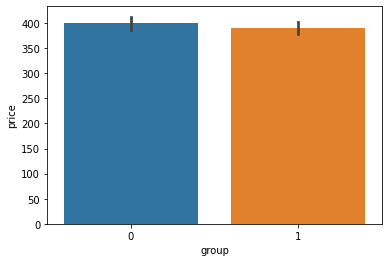

In [143]:
# Визуализация
sns.barplot(x='group', y='price', data=grouped_data)

Средняя стоимость заказа в тестовой группе уменьшилась приблизительно на 10 единиц.

Чтобы выбрать стат тест, проведем тест на нормальность распределений переменных.

In [144]:
print(ss.normaltest(control_orders_price))
print(ss.normaltest(test_orders_price))

NormaltestResult(statistic=365.34398549949304, pvalue=4.6404655245719645e-80)
NormaltestResult(statistic=971.4468931046567, pvalue=1.129763218272079e-211)


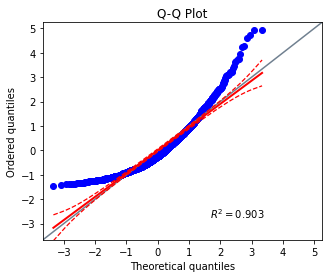

In [145]:
pg.qqplot(control_orders_price)

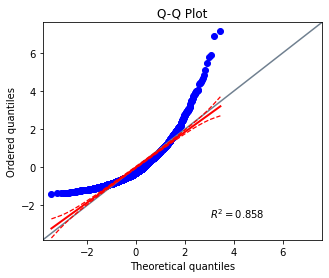

In [146]:
pg.qqplot(test_orders_price)

В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Имеем две непрерывные переменные (control_orders_price/test_orders_price), рапределение которых ненормально. Однако выборки большие → воспользуемся t-тестом.

- $H_0$: Средние значения для двух групп равны.
- $H_1$: Средние значения для двух групп не равны.

In [147]:
# Проведение теста t-теста
t_stat, p_value = ss.ttest_ind(control_orders_price, test_orders_price)
t_stat, p_value

(1.154160746782535, 0.24850119921938219)

In [148]:
p_value < 0.05 

False

**Вывод:** p-value > 0.05 → статистически значимого различия между группами нет. Новый алгоритм неэффективен в рамках данной метрики.

### Метрика 2: Количество заказов на пользователя

In [149]:
# Количество заказов на каждого пользователя в контрольной группе
control_users_order_count = control.groupby('user_id') \
    .order_id.nunique()

control_users_order_count.head()

user_id
964    2
966    1
968    3
969    2
972    1
Name: order_id, dtype: int64

In [150]:
# Среднее количество заказов на пользователя в контрольной группе
np.mean(control_users_order_count)

3.124271844660194

In [151]:
# Количество заказов на каждого пользователя в тестовой группе
test_users_order_count = test.groupby('user_id') \
    .order_id.nunique()

In [152]:
# Среднее количество заказов на пользователя в тестовой группе
np.mean(test_users_order_count)

5.00796812749004

Как видно, среднее количество заказов на пользователя в тестовой группе увеличилось. 

Чтобы выбрать стат тест, проведем тест на нормальность распределений переменных.

In [153]:
print(ss.normaltest(control_users_order_count))
print(ss.normaltest(test_users_order_count))

NormaltestResult(statistic=168.68174543124155, pvalue=2.350847085591091e-37)
NormaltestResult(statistic=21.897130007276793, pvalue=1.7583229075690624e-05)


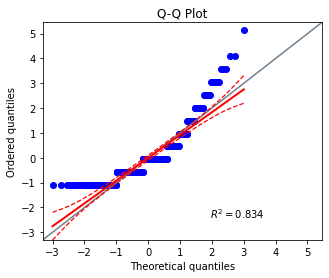

In [154]:
pg.qqplot(control_users_order_count)

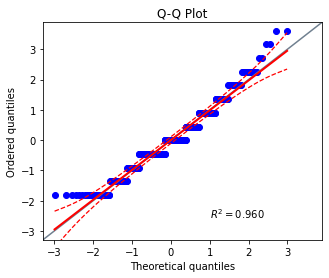

In [155]:
pg.qqplot(test_users_order_count)

В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Имеем две непрерывные переменные (control_users_order_count/test_users_order_count), рапределение которых ненормально. Однако выборки большие → воспользуемся t-тестом.

- $H_0$: Средние значения для двух групп равны.
- $H_1$: Средние значения для двух групп не равны.

In [156]:
# Проведение t-теста
t_stat, p_value = ss.ttest_ind(control_users_order_count, test_users_order_count)
t_stat, p_value

(-14.51086812343365, 1.6974865514796019e-43)

In [157]:
p_value < 0.05 

True

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами. Новый алгоритм эффективен в рамках данной метрики.

### Метрика 3: Среднее количество товаров в одном заказе

In [158]:
#orders['product_count'] = orders['product_ids'].apply(lambda x: len(x)) 

# Количество товаров в каждом заказе для контрольной группы
control_product_count = control.groupby('order_id').product_id.nunique()

In [159]:
# Среднее количество товаров в одном заказе для контрольной группы
np.mean(control_product_count)

3.28402734617775

In [160]:
# Количество товаров в каждом заказе для тестовой группы
test_product_count = test.groupby('order_id').product_id.nunique()

In [161]:
# Среднее количество товаров в одном заказе для тестовой группы
np.mean(test_product_count)

3.2879872712808274

Пока что явного различия в средних количествах товаров в одном заказе не наблюдается.

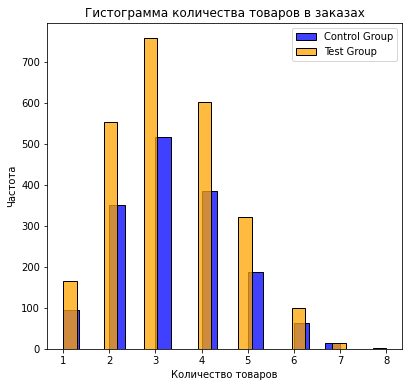

In [162]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(control_product_count, kde=False, color='blue', label='Control Group')
sns.histplot(test_product_count, kde=False, color='orange', label='Test Group')
plt.title('Гистограмма количества товаров в заказах')
plt.xlabel('Количество товаров')
plt.ylabel('Частота')
plt.legend()

На основе гистограммы, мы можем сделать следующие наблюдения:

Распределение количества товаров:
- В обоих группах наблюдается схожее распределение количества товаров в заказах.
- Наиболее частое количество товаров в заказе — это 3 или 4 товара, как для контрольной, так и для тестовой группы.

Частота заказов:
- В контрольной группе чаще встречаются заказы с 3 товарами.
- В тестовой группе также чаще встречаются заказы с 3 товарами.


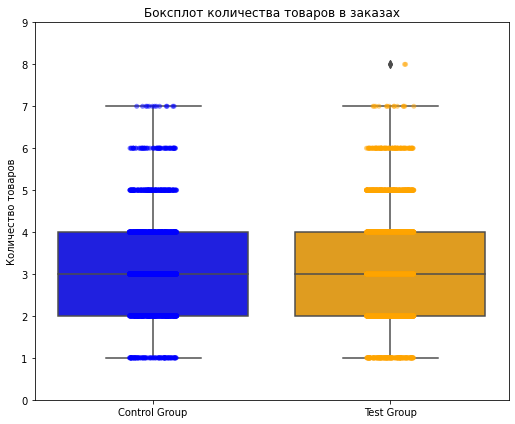

In [163]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.boxplot(data=[control_product_count, test_product_count], palette=['blue', 'orange'])
sns.stripplot(data=[control_product_count, test_product_count], palette=['blue', 'orange'], alpha=0.5, jitter=True)

plt.title('Боксплот количества товаров в заказах')
plt.xticks([0, 1], ['Control Group', 'Test Group'])
plt.ylabel('Количество товаров')

# Уменьшение диапазона оси Y для увеличения деталей
plt.ylim(0, max(max(control_product_count), max(test_product_count)) + 1)

plt.tight_layout()
plt.show()

Основные выводы:
- Медианы и межквартильные размахи в обеих группах схожи, что означает, что в среднем количество товаров в заказах примерно одинаково.
- Выбросы в тестовой группе показывают, что в этой группе есть заказы с существенно большим количеством товаров, чем в контрольной группе.

Тестовая группа имеет несколько заказов с более высоким количеством товаров, что может указывать на то, что новая система рекомендаций побуждает некоторых пользователей заказывать больше товаров. Однако, чтобы сделать окончательный вывод о значимости этого различия, нужно провести статистический тест.

Чтобы выбрать стат тест, проведем тест на нормальность распределений переменных.

In [164]:
print(ss.normaltest(control_product_count))
print(ss.normaltest(test_product_count))

NormaltestResult(statistic=33.82934726054547, pvalue=4.50869211002361e-08)
NormaltestResult(statistic=45.26057253686998, pvalue=1.4852226022198664e-10)


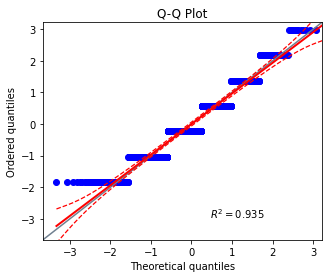

In [165]:
pg.qqplot(control_product_count)

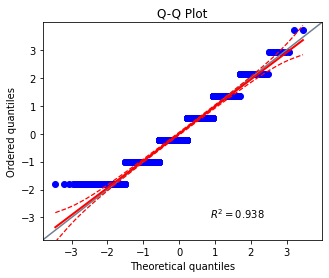

In [166]:
pg.qqplot(test_product_count)

В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Имеем две непрерывные переменные (control_product_count/test_product_count), рапределение которых ненормально. Однако выборки большие → воспользуемся t-тестом.

- $H_0$: Средние значения для двух групп равны.
- $H_1$: Средние значения для двух групп не равны.

In [167]:
# Проведение t-теста 
t_stat, p_value = ss.ttest_ind(control_product_count, test_product_count)
t_stat, p_value

(-0.09831810423573854, 0.9216844843645677)

In [168]:
p_value < 0.05 

False

**Вывод:** p-value > 0.05 → статистически значимого различия в среднем количестве товаров в одном заказе между группами нет. Это означает, что новая система рекомендаций не повлияла на количество товаров в заказах.

**Учет выбросов:** Выбросы могут свидетельствовать о наличии отдельных пользователей, которые совершают большие заказы, но в данном случае, если p-value > 0.05, это значит, что таких пользователей недостаточно для того, чтобы значимо повлиять на общую картину.

### Метрика 4: Средний чек

Средняя сумма, которую тратит каждый пользователь за все свои заказы.

In [169]:
# Сумма, которую тратит каждый пользователь в контрольной группе за все свои заказы
control_total_spendings = control.groupby('user_id') \
    .price.sum()

In [170]:
# Средняя сумма, которую тратит каждый пользователь в контрольной группе 
np.mean(control_total_spendings)

1249.5566990291263

In [171]:
# Сумма, которую тратит каждый пользователь в тестовой группе за все свои заказы
test_total_spendings = test.groupby('user_id') \
    .price.sum()

In [172]:
# Средняя сумма, которую тратит каждый пользователь в тестовой группе 
np.mean(test_total_spendings)

1951.8637450199205

Видно, что средняя сумма, которую тратит каждый пользователь в тестовой группе, значительно увеличилась по сравнению с контрольной.

Чтобы выбрать стат тест, проведем тест на нормальность распределений переменных.

In [173]:
print(ss.normaltest(control_total_spendings))
print(ss.normaltest(test_total_spendings))

NormaltestResult(statistic=152.1281716621266, pvalue=9.24245303810446e-34)
NormaltestResult(statistic=32.12661196656153, pvalue=1.0563184134031249e-07)


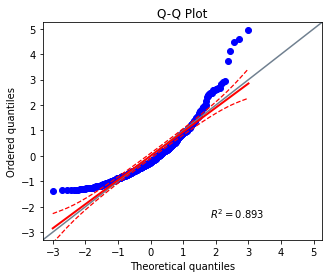

In [174]:
pg.qqplot(control_total_spendings)

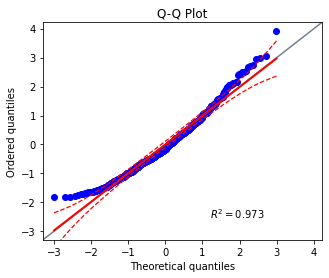

In [175]:
pg.qqplot(test_total_spendings)

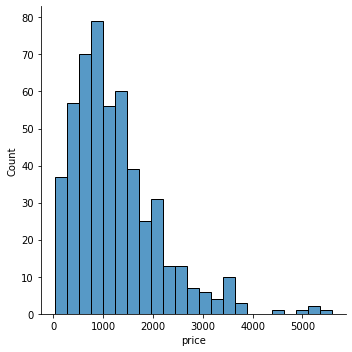

In [176]:
sns.displot(control_total_spendings)

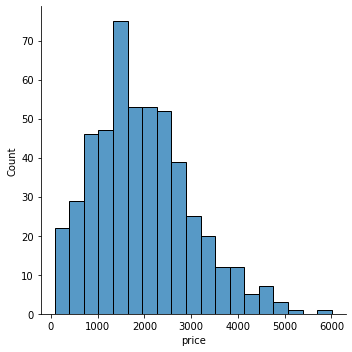

In [177]:
sns.displot(test_total_spendings)

В ходе неоднократной проверки пришли к выводу, что переменные распределены ненормально.

Имеем две непрерывные переменные (control_total_spendings/test_total_spendings), рапределение которых ненормально. Однако выборки большие → воспользуемся t-тестом.

- $H_0$: Средние значения для двух групп равны.
- $H_1$: Средние значения для двух групп не равны.

In [178]:
# Проведение t-теста 
t_stat, p_value = ss.ttest_ind(control_total_spendings, test_total_spendings)
t_stat, p_value

(-11.685795034334937, 1.0901045699351429e-29)

In [179]:
p_value < 0.05 

True

**Вывод:** p-value < 0.05 → существует статистически значимое различие между группами. Это означает, что новая система рекомендаций эффективно повлияла на средний чек.

## Выводы

На основе анализа четырех метрик, можно сделать выводы:

Новый алгоритм (тестовая группа) эффективен в увеличении количества заказов на пользователя и среднего чека.
Однако, статистически значимых изменений в средней стоимости заказа и среднем количестве товаров в одном заказе нет.

Введение тестовой группы стоит рассмотреть как целесообразное решение, так как:
- Положительное влияние на количество заказов на пользователя и средний чек показывает, что новый алгоритм стимулирует пользователей делать больше заказов и тратить больше денег.
- Несмотря на отсутствие изменений в средней стоимости заказа и среднем количестве товаров в заказе, увеличение среднего чека и количества заказов в целом позитивно скажется на выручке.

## Заключение
Рекомендуется внедрить новый алгоритм, так как его преимущества перевешивают отсутствие изменений в других метриках. 